<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/07_Natural_Language_Processing_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Natural Language Processing in Tensorflow
___

The main goal of natural language processing (NLP) is to derive information from natural language.
Natural language is a broad term but you can consider it to cover any of the following:
* Text (such as that contained in an email, blog post, book, Tweet)
* Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)

**What is NLP used for?**

Natural Language Processing is the driving force behind the following common applications:
* Language translation applications such as Google Translate
* Word Processors such as Microsoft Word and Grammarly that employ NLP to check grammatical accuracy of texts.
* Interactive Voice Response (IVR) applications used in call centers to respond to certain users’ requests.
* Personal assistant applications such as OK Google, Siri, Cortana, and Alexa.

**Workflow**
```
Download text -> Visualize Text -> turn into numbers (tokenization , embedding) -> build a model -> train the model to find patterns -> compare model -> ensemble model
```

`source` : 
* https://towardsdatascience.com/whatnlpscientistsdo-905aa987c5c0
* https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32
* https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e


# 0.0 Recurrent Neural Network

Another common term for NLP problems is sequence to sequence problems(seq2seq). RNN are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Typical Architecture of a RNN**

| Hyperparameter/Layer type | What does it do? | Typical values |
|---|---|---|
| Input text(s) | Target texts/sequences you'd like to discover patterns in | Whatever you can represent as text or a sequence |
| Input layer | Takes in target sequence | input_shape = [batch_size, embedding_size] or [batch_size , sequence_shape] |
| Text Vectorisation layer | Maps input sequence to layers | Multiple, can create with tf.keras.layers.preprocessing.TextVectorisation |
| Embedding | Turn mapping of text vectors to embedding matrix | Multiple, can create with tf.keras.layers.Embedding |
| RNN Cells | Find Pattern in Sequences | SimpleRNN , LSTM , GRU |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually Tanh (tf.keras.activations.tanh) |
| Pooling layer | Reduces the dimensionality of learned image features | Average (tf.keras.layers.GlobalAveragePooling1D) or Max (tf.keras.layers.GlobalMaxPool1D) |
| Fully connected layer | Further refines learned features from convolution layers | tf.keras.layers.Dense |
| Output layer | Takes learned features and outputs them in shape of target labels | output_shape = [number_of_classes] (e.g. disaster , Not Disaster) |
| Output activation | Adds non-linearities to output layer | tf.keras.activations.sigmoid (binary classification) or tf.keras.activations.softmax |


In [136]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split

import zipfile
import os

# 0.5 General Function
___

### TensorBoard Callbacks
___

In [137]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

### Classification Evaluation Metrics
___

In [138]:
def eval_classification(y_true , y_pred):

  from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

  # Define Scoring variables
  accuracy = accuracy_score(y_true , y_pred)
  precision = precision_score(y_true , y_pred)
  recall = recall_score(y_true , y_pred)
  f1_score = f1_score(y_true , y_pred)

  score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

  return score_dict

# 1.0 Getting Data from kaggle (Natural Language Processing with Disaster Tweets)
___

source : https://www.kaggle.com/philculliton/nlp-getting-started-tutorial

In [139]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-08-27 05:15:43--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.2’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-08-27 05:15:43 (102 MB/s) - ‘nlp_getting_started.zip.2’ saved [607343/607343]



In [140]:
# Unzip file
zip_ref = zipfile.ZipFile('nlp_getting_started.zip')
zip_ref.extractall()
zip_ref.close()

In [141]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 1.1 Visualising Data
___

In [142]:
# Checking Training Data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [143]:
df_train = df_train.sample(frac = 1 , random_state = 42)
df_train.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [144]:
# Checking Test Data
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [145]:
# Target True : False Ratio
df_train['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [146]:
random_index = random.randint(0 , len(df_train))
df_train[['text' , 'target']].head()

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0


In [147]:
random_index = random.randint(0 , len(df_train))

for row in df_train[['text' , 'target']][random_index : random_index +5].itertuples():
  _ , text , target = row

  print(f"Target: {target}" , "(Disaster)" if target > 0 else "(Not Disaster)")
  print(f'Text: {text}')
  print('-------\n')

Target: 0 (Not Disaster)
Text: I am that girl on tv that sadly turns her music up to drown out the noise of her family fighting literally every day
-------

Target: 0 (Not Disaster)
Text: #MrRobinson is giving me #TheSteveHarveyShow vibe. Music teacher looks out for students has crush on girl he went to high school with. ??
-------

Target: 0 (Not Disaster)
Text: @abran_caballero Discovered by @NickCannon 
 Listen/Buy @realmandyrain #RIOT on @iTunesMusic @iTunes https://t.co/dehMym5lpk Û_ #BlowMandyUp
-------

Target: 1 (Disaster)
Text: @AdamRubinESPN Familia: arm injury or head case?
-------

Target: 0 (Not Disaster)
Text: Had a minute alone with my crush??...it was an overrated experience...smh
-------



### 1.2 Data Split Training and Validation
___

In [148]:
# Define X and y variables
train = df_train['text'].to_numpy()
val = df_train['target'].to_numpy()

In [149]:
train_sentences , val_sentences ,train_label , val_label = train_test_split(train , val , test_size = 0.1 , random_state  = 42)

In [150]:
print(f'Train Sentence: {train_sentences.shape}')
print(f'Val Sentence: {val_sentences.shape}')
print(f'Train Label: {train_label.shape}')
print(f'Val Label: {val_label.shape}')

Train Sentence: (6851,)
Val Sentence: (762,)
Train Label: (6851,)
Val Label: (762,)


### 1.3 Converting Text into Numbers
___

* Tokenization : Straight mapping from token to number , however model can get very big as no. of words increases.
* Embedding : Representation by vector , weighted matrix. Richer representation of relationship between tokens.

#### 1.3.1 Tokenization
___

In [151]:
# # Default Setting of TextVectorisation
# text_vectorizer = TextVectorization(max_tokens = None,
#                                     standardize = 'lower_and_strip_punctuation',
#                                     split = 'whitespace',
#                                     ngrams = None, # grouping of words
#                                     output_mode = 'int',
#                                     output_sequence_length = None,
#                                     pad_to_max_tokens = True) 

In [152]:
#   This example instantiates a `TextVectorization` layer that lowercases text, splits on whitespace, strips punctuation, and outputs integer vocab indices.

max_vocab_length = 10000  # Max number of words in our vocab
max_length = 15 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

In [153]:
text_vectorizer.adapt(train_sentences)

In [154]:
# Our max_length is set as 15 and our sentence only have 7 words. The rest of the 8 remaining words are padded with 0s.
sample_sentence = 'There is a flood in Bukit Timah'
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([ 74,   9,   3, 232,   4,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0])>

In [155]:
# Visualing random sentence from our training dataset.
random_sentence = random.choice(train_sentences)
print(f'Originial Sentence: {random_sentence}')
print('--------')
print(f'Vectorized Sentence: {text_vectorizer(random_sentence)}')

Originial Sentence: Roof collapsed a bowling alley many in the community remember going to for more than 30 years @KEZI9 http://t.co/sAhbhLXsSh
--------
Vectorized Sentence: [1773  439    3 4067    1  123    4    2 1540  594  104    5   10   51
   76]


In [156]:
# Checking the unique vocabulary
word_in_vocab = text_vectorizer.get_vocabulary()
print(f'Top 10 words: {word_in_vocab[:10]}')
print(f'Bottom 10 words: {word_in_vocab[-10:]}')

Top 10 words: ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
Bottom 10 words: ['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


#### 1.3.2 Embedding
___

* Key Parameters for embedding layer:
  - `input_dim` = size of our vocab
  - `output_dim` = size of our output embedding vector. A value of 100 would mean each token get represented by a vector 100 long
  - `input_length` = length of the sequences being passed to the embedding layer

In [157]:
embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length)
embedding

In [158]:
# Visualing random sentence from our training dataset.
random_sentence = random.choice(train_sentences)

print(f'Original Sentence : {random_sentence}')
print('--------')
print(f'Embedded Sentence : {embedding(text_vectorizer(random_sentence)).shape}')
print(f'Embedded Sentence : {embedding(text_vectorizer(random_sentence))}')

Original Sentence : my school just put the evacuation alarms on accidently with 2 different trial exams happening are you kidding me
--------
Embedded Sentence : (15, 128)
Embedded Sentence : [[ 0.02008813  0.02426716  0.00856415 ...  0.04177744 -0.03308376
   0.04519632]
 [-0.03625976  0.02497682  0.03676352 ...  0.04159256 -0.00940251
  -0.04070119]
 [ 0.00614863 -0.04565636 -0.04848944 ... -0.01220351  0.03431812
  -0.02314569]
 ...
 [-0.00281845  0.03760764 -0.03954209 ...  0.0362852  -0.01278483
   0.02718944]
 [ 0.02851376 -0.00032163  0.02226352 ... -0.02951096  0.00688358
  -0.01408608]
 [-0.02041154 -0.01500582 -0.04919515 ...  0.00630901 -0.03791144
   0.0470585 ]]


### 1.4 Model 0 : Baseline Model with Naive Bayes with TF_IDF encoder
___

* Model 0 : Naive Bayes with TF-IDF encoder
* Model 1 : Feed-Forward neural network (dense)
* Model 2 : LSTM model (RNN)
* Model 3 : GRU model (RNN)
* Model 4 : Bidirectional - LSTM model (RNN)
* Model 5 : 1D CNN
* Model 6 : TF Hub Pretrained Feature Extractor
* Model 7 : TF Hub Pretrained Feature Extractor with 10% data.

In [159]:
model_0 = Pipeline([
                    ('tfidf' , TfidfVectorizer()), # convert words to numbers using tfidf
                    ('clf' , MultinomialNB()) #model the text
])

model_0.fit(train_sentences , train_label)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [160]:
# Baseline model score
model_0.score(val_sentences , val_label)
model_0_preds = model_0.predict(val_sentences)

In [161]:
eval_classification(y_true = val_label , y_pred = model_0_preds)

{'Accuracy': 0.7926509186351706,
 'F1 Score': 0.734006734006734,
 'Precision': 0.8861788617886179,
 'Recall': 0.6264367816091954}

### 1.5 Model 1 : Feed Forward Neural Network
___

In [162]:
# Build model with the functional API

inputs = layers.Input(shape = (1,) , dtype = tf.string) # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the text into numbers
x = embedding(x) # create an embedding 
# x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs = inputs , outputs = outputs , name ='model_1')

In [163]:
# Observed that the output layer is not 1 output , but somehow related to our token count.
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
dense_19 (Dense)             (None, 15, 1)             129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [164]:
# Build model with the functional API

inputs = layers.Input(shape = (1,) , dtype = tf.string) # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the text into numbers
x = embedding(x) # create an embedding 
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs = inputs , outputs = outputs , name ='model_1')

In [165]:
# Observed that after passing through the Pooling1D , the feature vector for each token is condense into 1 output
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [166]:
# Tensorboard Save directory
save_dir = 'model_logs'

model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_1 = model_1.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences, val_label),
                        callbacks = [create_tensorboard_callback(dir_name = save_dir , 
                                                                 experiment_name = 'model_1_Dense')])

Saving Tensorboard log files to model_logs/model_1_Dense/20210827-051545
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.6132 - accuracy: 0.6887 - val_loss: 0.5403 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4424 - accuracy: 0.8183 - val_loss: 0.4726 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3469 - accuracy: 0.8586 - val_loss: 0.4585 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2840 - accuracy: 0.8905 - val_loss: 0.4634 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2375 - accuracy: 0.9132 - val_loss: 0.4815 - val_accuracy: 0.7822


In [167]:
# Model 1 Score
model_1.evaluate(val_sentences , val_label)

24/24 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.7822


[0.48147666454315186, 0.7821522355079651]

In [168]:
# Checking test_prediction with actual label
model_1_preds = model_1.predict(val_sentences)
print(f' Sample Test Prediction : {model_1_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[0.9880214 ]
 [0.02759576]
 [0.9007293 ]
 [0.74551964]
 [0.08092564]
 [0.35062972]
 [0.11417606]
 [0.81170136]
 [0.38541162]
 [0.01060382]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [169]:
# formatting test prediction to 0 and 1 format

model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [170]:
model_1_results = eval_classification(val_label , model_1_preds)
model_1_results

{'Accuracy': 0.7821522309711286,
 'F1 Score': 0.7389937106918238,
 'Precision': 0.8159722222222222,
 'Recall': 0.6752873563218391}

#### 1.5.1 Visualing via tensorflow projector
___
- [Tensorflow Projector](https://projector.tensorflow.org/)
- [Word Embedding](https://www.tensorflow.org/text/guide/word_embeddings)

In [171]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab) , words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [173]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
embed_weights = model_1.get_layer('embedding_2').get_weights()[0]
embed_weights.shape

(10000, 128)

In [174]:
# Create Embedding files (we got this from Tensorflow's word embedding documentation)

import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [175]:
# Download file from Colab to upload to projector (we got this from Tensorflow's word embedding documentation)
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p align = 'center'>
  Extract from Tensorflow Projector for Model_1 (Load Vector.tsv and metadata.tsv)
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/08-tf_projector.png'>
</p>

### 1.6 Model 2 : LSTM (Long Short Term Memory)
___

One Simplified typical Structure of an RNN :
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs / Dense) -> Output (label probability)
```

**Input non-linear function for RNN is `tanh`**
 - Compared to sigmoid, tanh squeezes the input and passes through the origin.


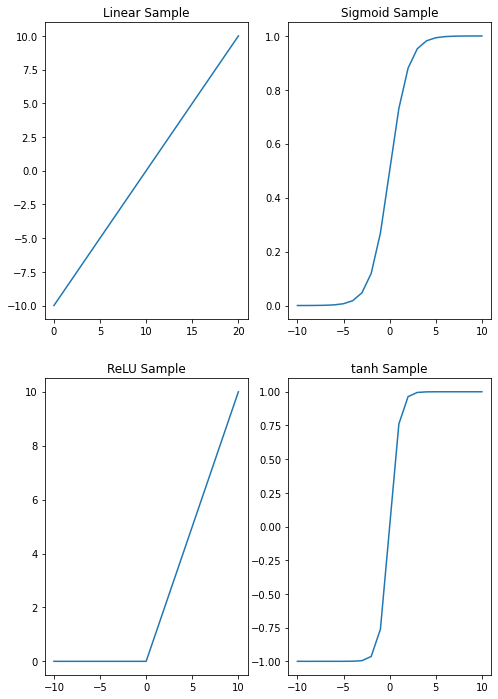

In [176]:

import tensorflow as tf
import matplotlib.pyplot as plt
# Passing a linear range
sample_linear = tf.range(-10,11 , dtype = tf.float32)

# 
def sigmoid(x):
  return 1/(1+tf.exp(-x))

def relu(x):
  return tf.maximum(0 , x)

def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))


# Passing linear range via the sigmoid and relu function
sample_sigmoid = sigmoid(sample_linear)
sample_relu = relu(sample_linear)
sample_tanh = tanh(sample_linear)

plt.figure(figsize = (8 , 12))

# Linear Activation - Same as Linear line
plt.subplot(2,2,1)
plt.plot(sample_linear)
plt.title('Linear Sample')

# Sigmoid Activation
plt.subplot(2,2,2)
plt.plot(sample_linear , sample_sigmoid)
plt.title('Sigmoid Sample')

# ReLU Activation
plt.subplot(2,2,3)
plt.plot(sample_linear , sample_relu)
plt.title('ReLU Sample');

# tanh Activation
plt.subplot(2,2,4)
plt.plot(sample_linear , sample_tanh)
plt.title('tanh Sample');

In [177]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,) , dtype = 'string') # inputs are 1D String
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units = 64 , return_sequences = True)(x) 
print(x.shape)
x = layers.LSTM(64)(x) # RNN is recurring , so it take it previous loop. Have to be same as previous
print(x.shape)
# x = layers.Dense(64 , activation = 'relu')(x)
# print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs = inputs , outputs = outputs , name= 'model_2')

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [178]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 1,362,497
Trainable params: 1,362,497
Non-trainable params: 0
_________________________________________________

In [179]:
model_2.compile(optimizer= tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_2 = model_2.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        callbacks = [create_tensorboard_callback(dir_name = save_dir,
                                                                 experiment_name = 'model_2_LSTM')],
                        validation_data = (val_sentences , val_label))

Saving Tensorboard log files to model_logs/model_2_LSTM/20210827-051643
Epoch 1/5
215/215 [==============================] - 14s 46ms/step - loss: 0.2138 - accuracy: 0.9228 - val_loss: 0.5488 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.1588 - accuracy: 0.9422 - val_loss: 0.5537 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 9s 41ms/step - loss: 0.1296 - accuracy: 0.9514 - val_loss: 0.6949 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 9s 41ms/step - loss: 0.1043 - accuracy: 0.9603 - val_loss: 0.8389 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0806 - accuracy: 0.9683 - val_loss: 1.1217 - val_accuracy: 0.7612


In [180]:
# Checking test prediction with actual label
model_2_preds = model_2.predict(val_sentences)
print(f' Sample Test Prediction : {model_2_preds[-10:]}')
print('----------------------')
print(f' Actual Label : {val_label[-10:]}')

 Sample Test Prediction : [[9.9996704e-01]
 [2.1460652e-04]
 [9.9995768e-01]
 [9.9946952e-01]
 [5.1054358e-02]
 [1.6627160e-01]
 [4.6833014e-01]
 [9.5812774e-01]
 [3.6590901e-01]
 [1.9496679e-04]]
----------------------
 Actual Label : [1 0 1 1 0 0 0 0 0 0]


In [181]:
# formatting prediction to 0 and 1 format

model_2_preds = tf.squeeze(tf.round(model_2_preds))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [182]:
# Getting the results
model_2_results = eval_classification(y_pred = model_2_preds, y_true = val_label )
model_2_results

{'Accuracy': 0.7611548556430446,
 'F1 Score': 0.7369942196531792,
 'Precision': 0.7412790697674418,
 'Recall': 0.7327586206896551}

### 1.7 Model 3 : GRU (Gated Recurrent Network)
___

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al.The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM. GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets.

Source : https://en.wikipedia.org/wiki/Gated_recurrent_unit


  - Recap on flow process

  ```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs / Dense) -> Output (label probability)
  ```

In [220]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.GRU(64 , return_sequences = True)(x) #return sequence = true if want to stack recurrent layers
print(x.shape)
x = layers.LSTM(42 , return_sequences = True)(x)
print(x.shape)
x = layers.GRU(99)(x)
print(x.shape)
# x = layers.Dense(64 , activation = 'relu')(x)
outputs = layers.Dense(1 , activation  = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs ,outputs , name = 'model_3')

(None, 15, 128)
(None, 15, 64)
(None, 15, 42)
(None, 99)


In [221]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
gru_33 (GRU)                 (None, 15, 64)            37248     
_________________________________________________________________
lstm_38 (LSTM)               (None, 15, 42)            17976     
_________________________________________________________________
gru_34 (GRU)                 (None, 99)                42471     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 100 

In [ ]:
model_3.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = 'accuracy')

history_3 = model_3.fit(train_sentences,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentences , val_label),
                        callbacks = [create_tensorboard_callback(save_dir , 'model_3_GRU')])

Saving Tensorboard log files to model_logs/model_3_GRU/20210827-054330
Epoch 1/5
215/215 [==============================] - 17s 57ms/step - loss: 0.1048 - accuracy: 0.9663 - val_loss: 1.2822 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 11s 49ms/step - loss: 0.0519 - accuracy: 0.9781 - val_loss: 1.0610 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0446 - accuracy: 0.9791 - val_loss: 1.3703 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 11s 51ms/step - loss: 0.0407 - accuracy: 0.9799 - val_loss: 1.6539 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0460 - accuracy: 0.9781 - val_loss: 1.1750 - val_accuracy: 0.7703
